<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [230]:
#bringing my armies
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [231]:
# Load the data
house = pd.read_csv('./datasets/housing.csv')
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [232]:
house.head() #check first 5 rows 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [233]:
house.sample(10) #randomly sample 10 rows

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
76,77,20,RL,NaN,8475,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,135750
428,429,20,RL,64.0,6762,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,New,Partial,195400
94,95,60,RL,69.0,9337,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,204750
427,428,20,RL,77.0,8593,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,109008
990,991,60,RL,82.0,9452,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,348000
935,936,30,RL,52.0,5825,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,79900
1317,1318,120,FV,47.0,4230,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2007,New,Partial,208900
1365,1366,60,FV,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,216000
525,526,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,176000
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000


In [234]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [235]:
#remove any houses that are not residential from the dataset.
house=house[house.MSZoning!='C (all)']

In [236]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [237]:
house.shape

(1450, 81)

In [238]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## EDA

### Target variable

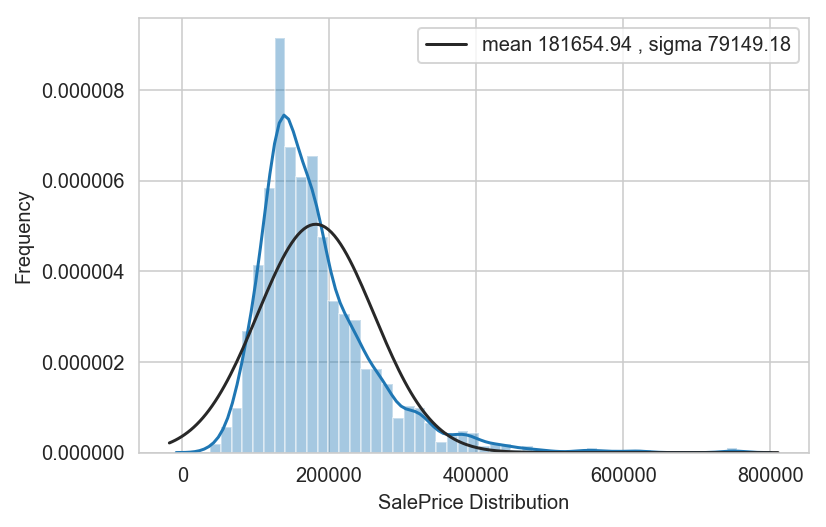

In [239]:
#Histogram shows the SalePrice is skewed to the right and we need to make it more normally distributed
sns.distplot(house.SalePrice,fit=norm) 
plt.xlabel('SalePrice Distribution')
plt.ylabel('Frequency')
(mu,sigma) = norm.fit(house.SalePrice)
plt.legend(['mean {:.2f} , sigma {:.2f}'.format(mu,sigma)],loc='best');

#### I found out both OverallQual and SalePrice are highly corelatted hence I wanted to re-investigate using absolute SalePrice that is un-logged. OverallQual seems ok compared to GrLivArea which has 2 outliers around the > 4500 GrLivArea mark.

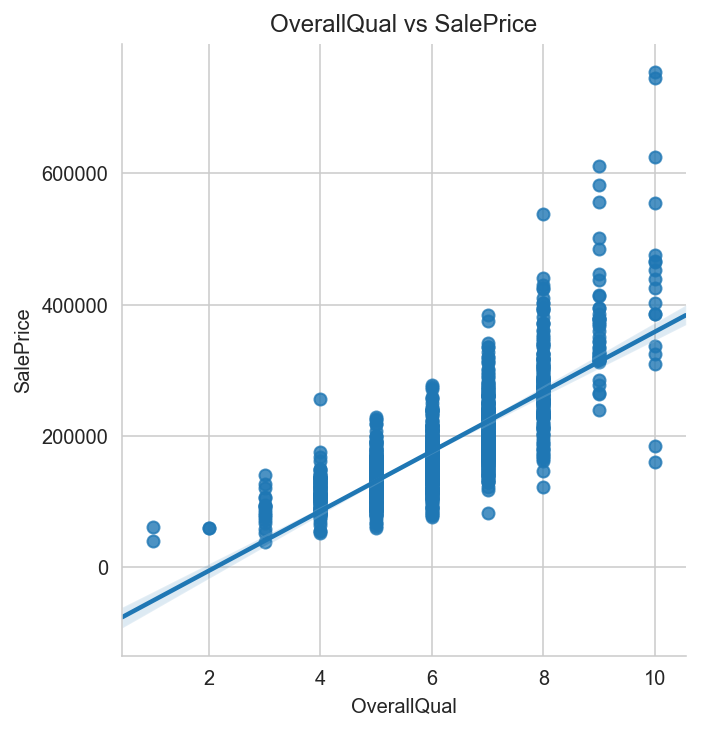

In [240]:
# Plot the first 2 parameters based on Spearman & Pearson that I did below

sns.lmplot(x='OverallQual',y='SalePrice',data=house)
plt.title('OverallQual vs SalePrice');

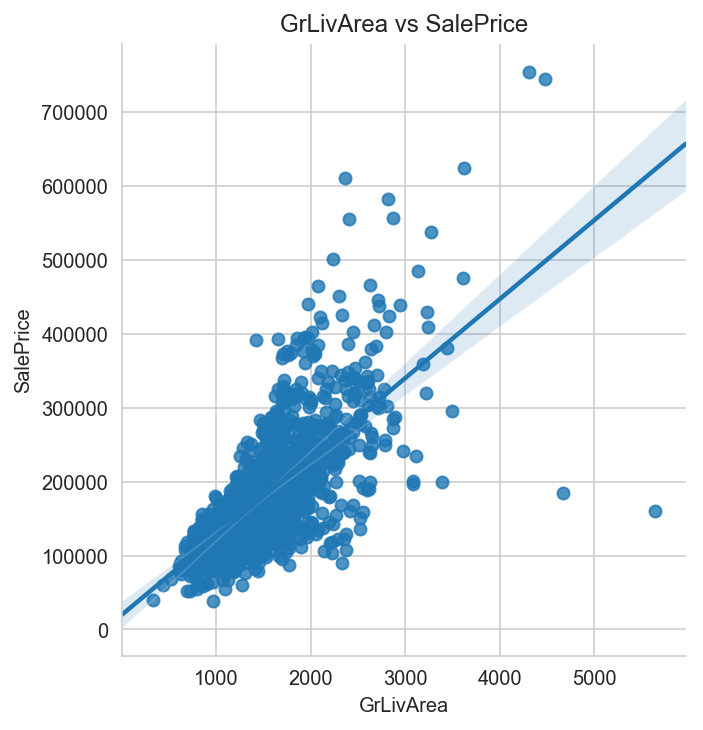

In [241]:
sns.lmplot(x='GrLivArea',y='SalePrice',data=house)
plt.title('GrLivArea vs SalePrice');

In [242]:
#determine the index of the 2 outliers
outlier=house[(house.GrLivArea>4500) & (house.SalePrice<200000)].index
house.drop(outlier,inplace=True)

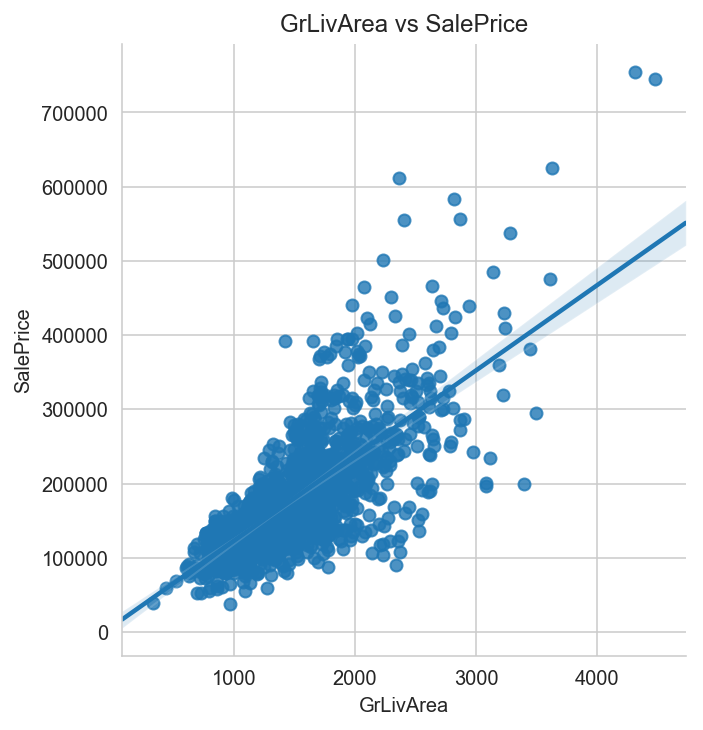

In [243]:
#the 2 outliers are exterminated!
sns.lmplot(x='GrLivArea',y='SalePrice',data=house)
plt.title('GrLivArea vs SalePrice');

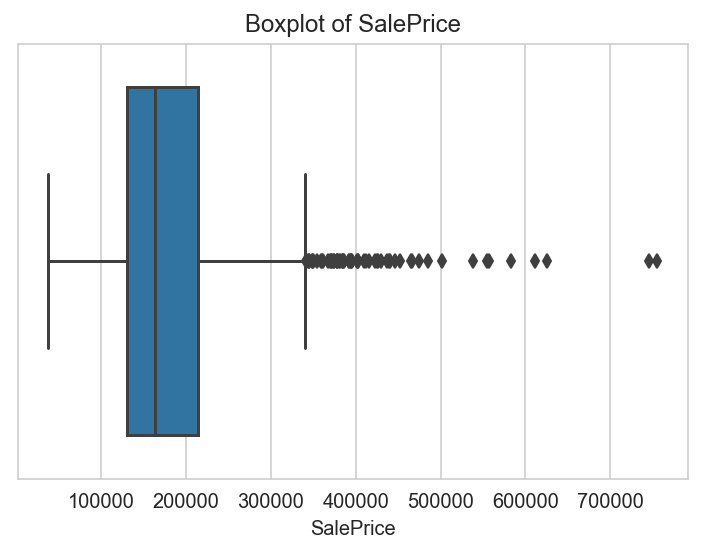

In [244]:
#check outliers of target variable
sns.boxplot('SalePrice',data=house)
plt.title('Boxplot of SalePrice');

In [245]:
# Computing IQR
print(f'Before removing outliers: {house.shape}')
Q1 = house.SalePrice.quantile(0.25)
Q3 = house.SalePrice.quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-3IQR and Q3+3IQR ( More conservative setting )
house = house.query('(@Q1 - 3 * @IQR) <= SalePrice <= (@Q3 + 1.5 * @IQR)')
print(f'After removing outliers: {house.shape}')

Before removing outliers: (1448, 81)
After removing outliers: (1387, 81)


### Log transformation

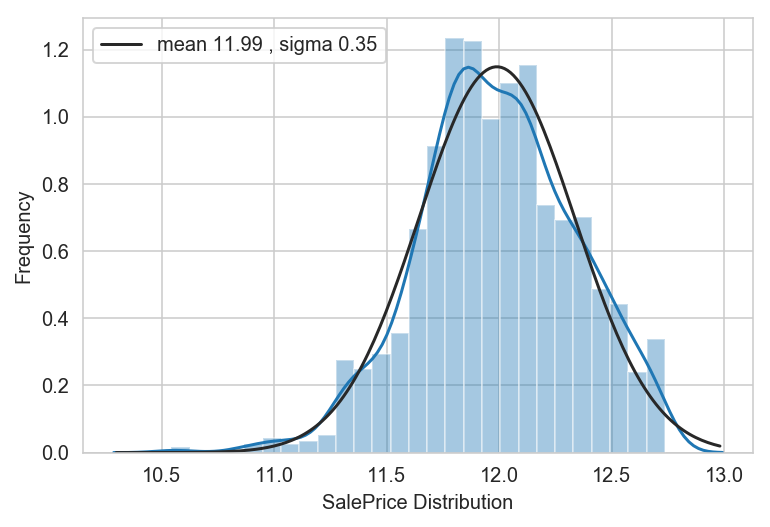

In [246]:
#log Saleprice to normalise the data
house['SalePrice']=np.log1p(house.SalePrice)
sns.distplot(house.SalePrice,fit=norm)
plt.xlabel('SalePrice Distribution')
plt.ylabel('Frequency')
(mu,sigma) = norm.fit(house.SalePrice)
plt.legend(['mean {:.2f} , sigma {:.2f}'.format(mu,sigma)],loc='best');

## Feature engineering

### Missing Data

In [247]:
#check % data that is null
total=pd.DataFrame({'is_null':house.isnull().sum().sort_values(ascending=False)}) #determine columns with missing values
total['Percentage']= total.is_null/len(house)
total=total[total.is_null!=0]
total

,is_null,Percentage
PoolQC,1382,0.996395
MiscFeature,1335,0.962509
Alley,1298,0.935833
Fence,1113,0.802451
FireplaceQu,680,0.490267
LotFrontage,256,0.184571
GarageCond,79,0.056957
GarageType,79,0.056957
GarageYrBlt,79,0.056957
GarageFinish,79,0.056957


In [248]:
total.index #columns that is_null

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrArea', 'MasVnrType', 'Electrical'],
      dtype='object')

In [249]:
cat=house.dtypes[house.dtypes=='object'].index #columns that are categorical

In [250]:
cont=house.dtypes[house.dtypes!='object'].index #columns that is continuous

### Data Corelation

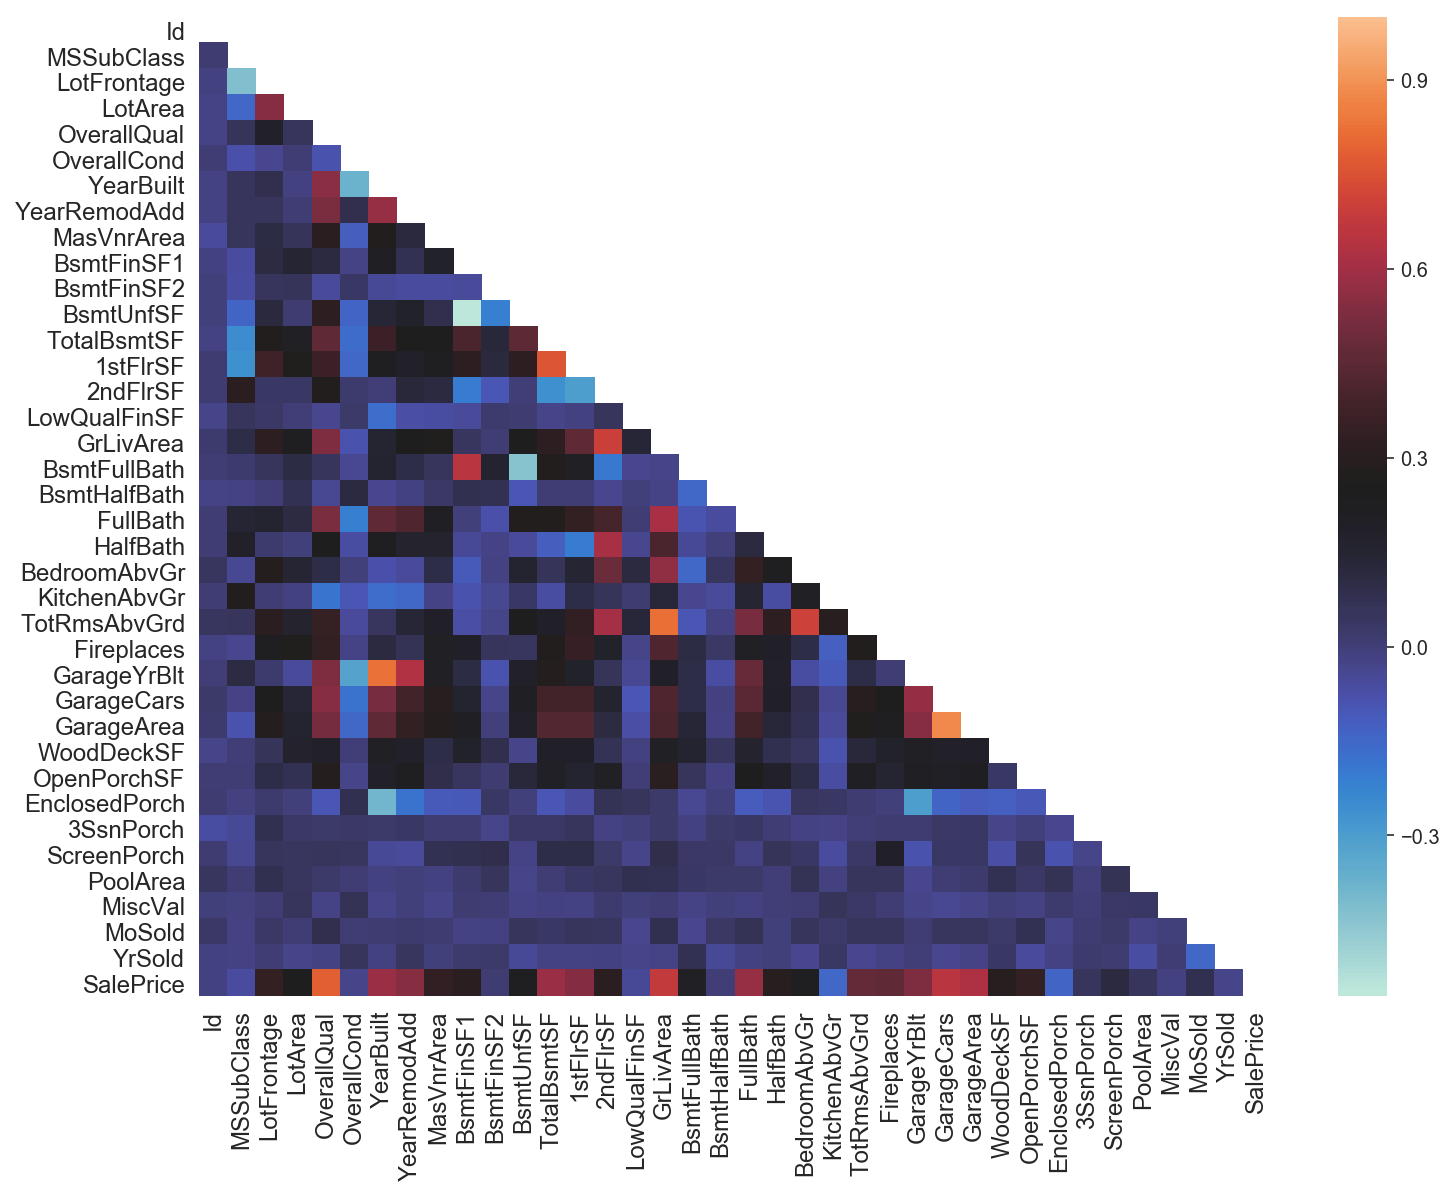

In [251]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,9))


    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True


    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, center=0.25,mask=mask, annot=False)


    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)


    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(house)

In [252]:
#Pearson corelation with SalePrice
house.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.785940
GrLivArea        0.682402
GarageCars       0.648244
GarageArea       0.629104
TotalBsmtSF      0.583091
YearBuilt        0.581978
FullBath         0.578985
YearRemodAdd     0.550637
1stFlrSF         0.540458
GarageYrBlt      0.531257
TotRmsAbvGrd     0.475644
Fireplaces       0.455589
OpenPorchSF      0.340836
LotFrontage      0.340147
MasVnrArea       0.333550
2ndFlrSF         0.312868
BsmtFinSF1       0.307876
WoodDeckSF       0.297021
HalfBath         0.295264
LotArea          0.251468
BsmtUnfSF        0.221215
BedroomAbvGr     0.219388
BsmtFullBath     0.201221
ScreenPorch      0.116701
MoSold           0.077840
PoolArea         0.052996
3SsnPorch        0.050597
BsmtFinSF2       0.015776
BsmtHalfBath    -0.000960
Id              -0.010151
MiscVal         -0.013020
OverallCond     -0.026526
YrSold          -0.030140
LowQualFinSF    -0.049124
MSSubClass      -0.057304
EnclosedPorch   -0.140551
KitchenAbvGr    -0.152308
Name: SalePr

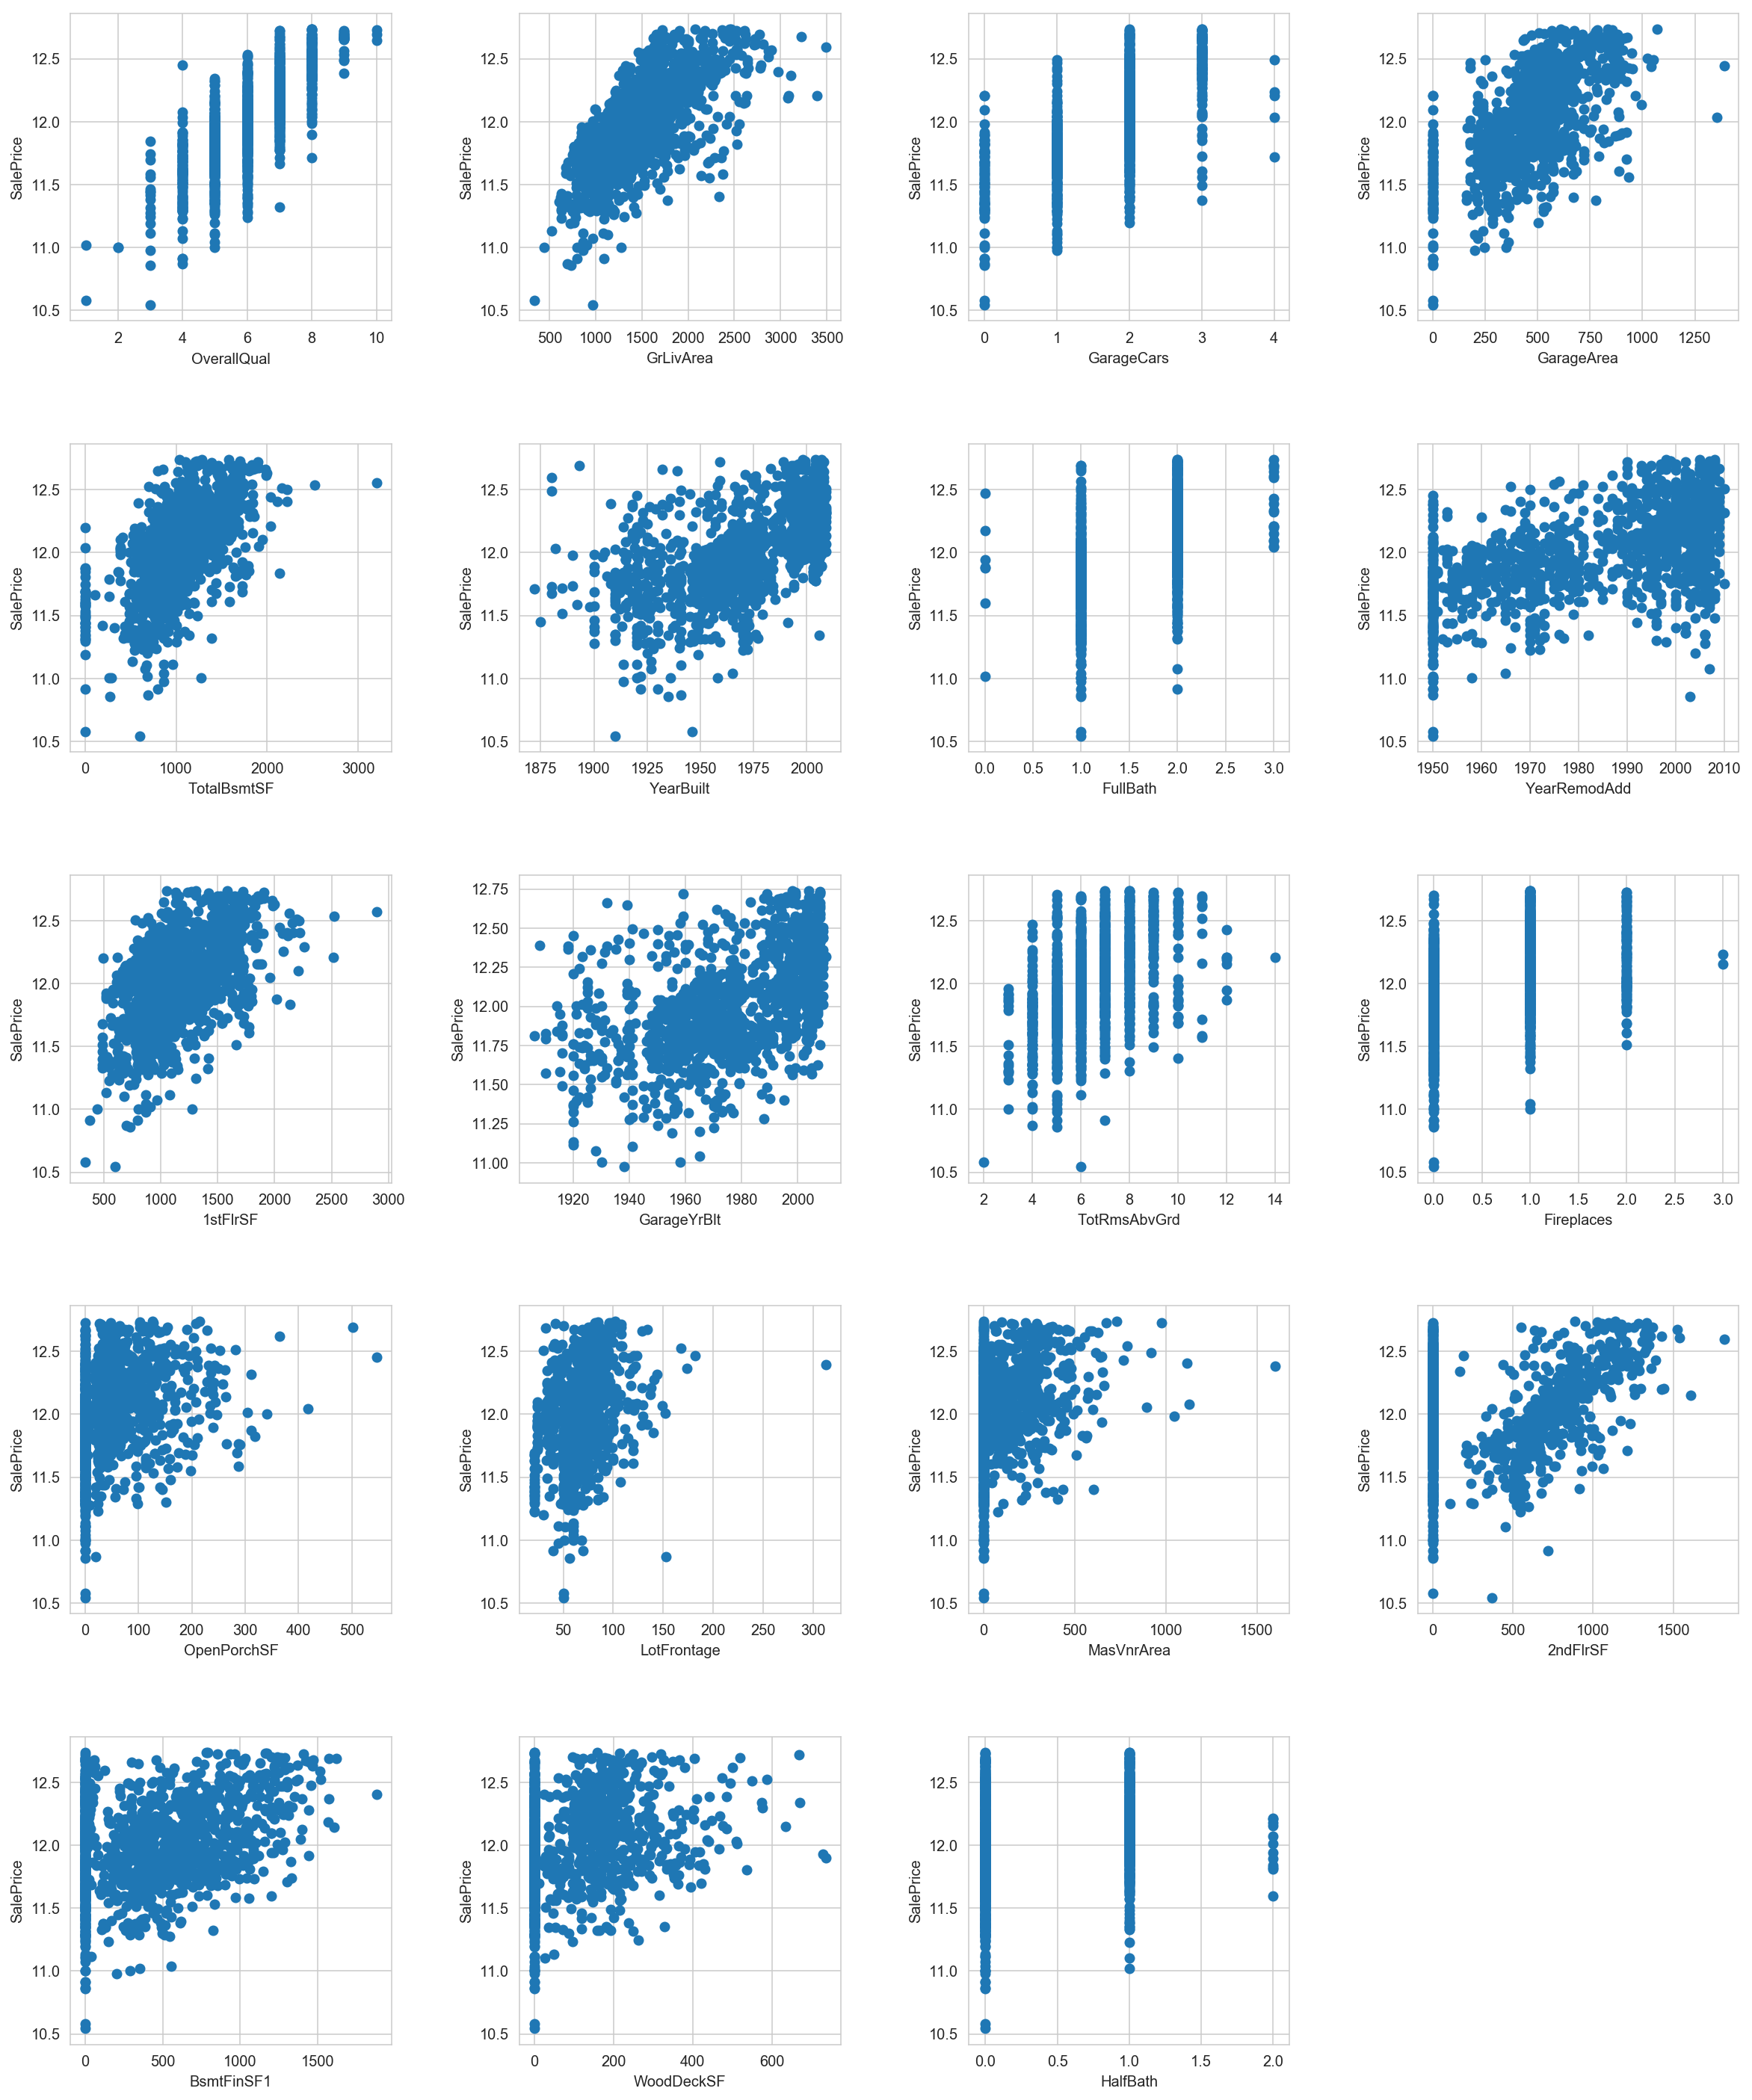

In [253]:
# Plot the first 20 parameters based on Pearson
columns = abs(house.corr(method='pearson')['SalePrice']).sort_values(ascending=False)[1:20].index.values
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 4, i)
    ax.scatter(x=columns[i-1], y='SalePrice', data=house)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('SalePrice')

In [254]:
#Rank Spearman corelation with SalePrice
house.corr(method='spearman')['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.784255
GrLivArea        0.707182
GarageCars       0.657815
YearBuilt        0.631349
GarageArea       0.622385
FullBath         0.621904
GarageYrBlt      0.567799
TotalBsmtSF      0.559610
YearRemodAdd     0.542139
1stFlrSF         0.525860
TotRmsAbvGrd     0.498883
Fireplaces       0.486832
OpenPorchSF      0.467336
LotArea          0.420935
LotFrontage      0.384876
MasVnrArea       0.372782
HalfBath         0.325398
WoodDeckSF       0.322444
2ndFlrSF         0.297834
BsmtFinSF1       0.255426
BedroomAbvGr     0.236057
BsmtUnfSF        0.191401
BsmtFullBath     0.189660
ScreenPorch      0.098516
MoSold           0.072417
3SsnPorch        0.061679
PoolArea         0.057097
MSSubClass       0.024394
BsmtHalfBath    -0.005993
Id              -0.009977
YrSold          -0.022671
BsmtFinSF2      -0.030521
MiscVal         -0.042802
LowQualFinSF    -0.067971
OverallCond     -0.122011
KitchenAbvGr    -0.161895
EnclosedPorch   -0.208981
Name: SalePr

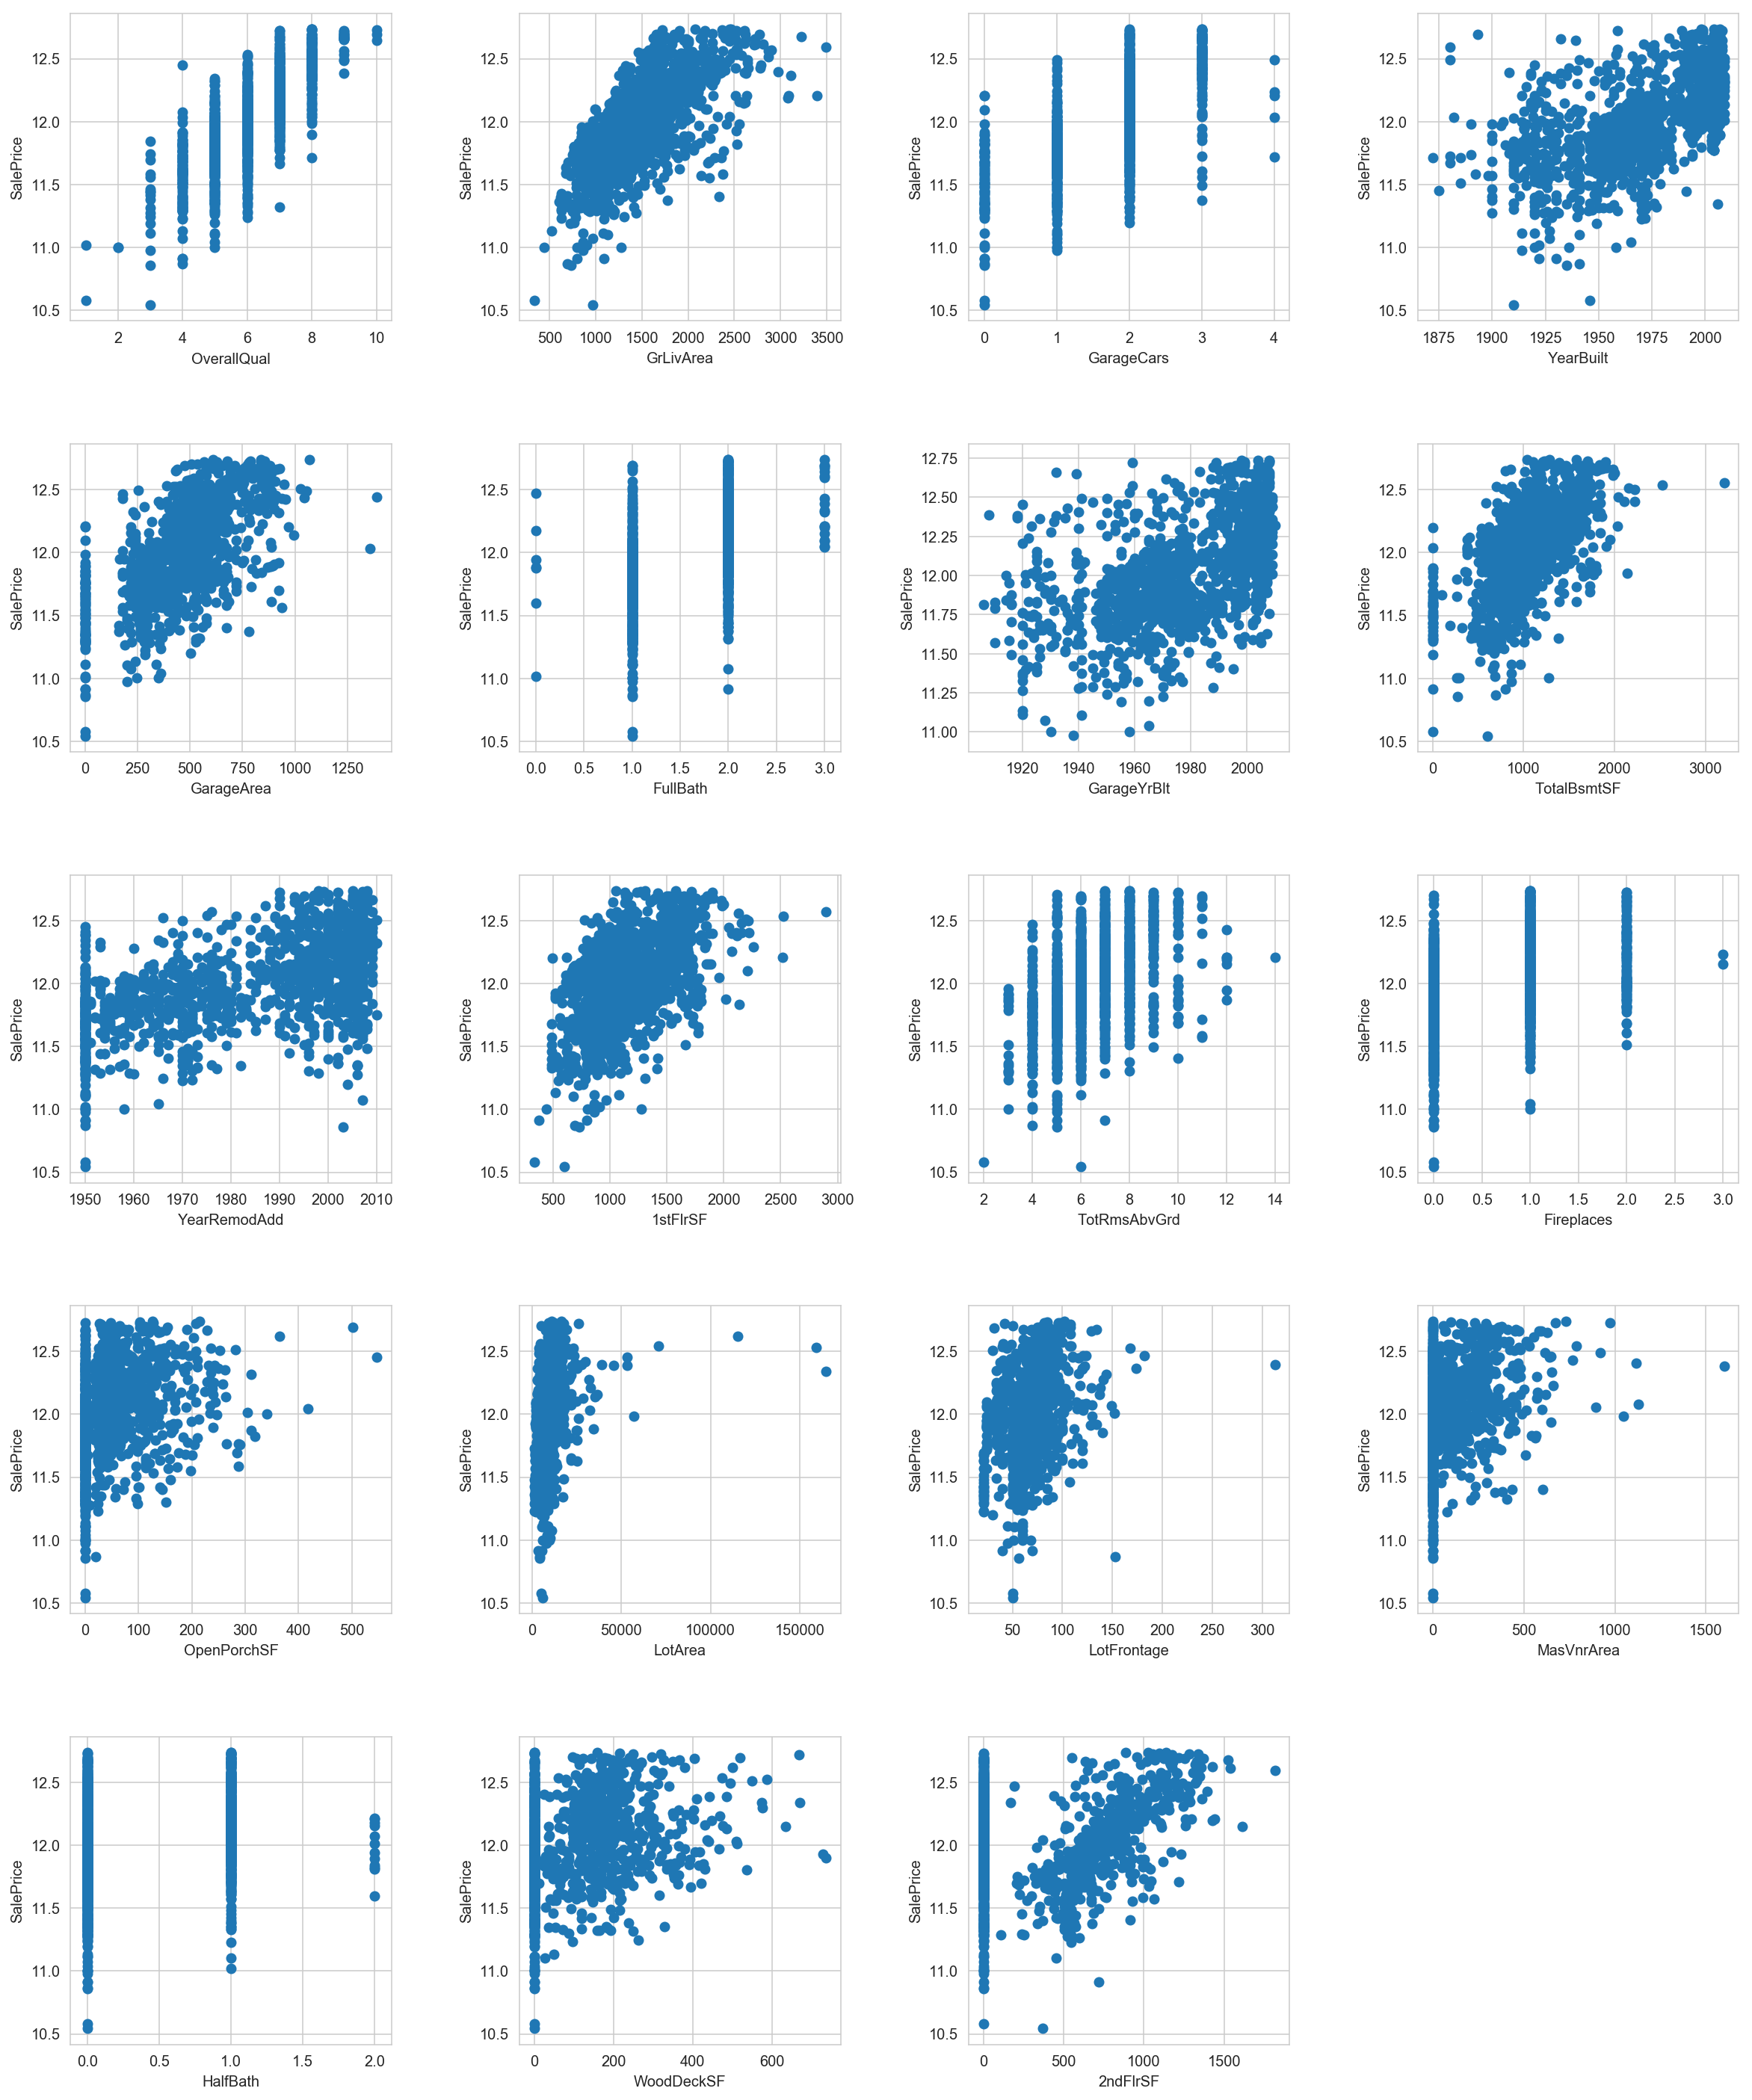

In [255]:
# Plot the first 20 parameters based on Spearman
columns = abs(house.corr(method='spearman')['SalePrice']).sort_values(ascending=False)[1:20].index.values
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 4, i)
    ax.scatter(x=columns[i-1], y='SalePrice', data=house)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('SalePrice')

#### Based on the heatmaps, preliminary EDA indicates the following are the 3 features for continuous variables that are signifcant w.r.t SalePrice.

The above provide a sense for us to understand the predictor variables that will affect SalePrice.

Selection condition :
Scatter plot that looks linear are considered with Pearson or Spearman value > 0.6

['TotalSF','GrLivArea','GarageArea'] 



### Dropping predictor variables

In [256]:
house.Electrical.unique()
#drop Id  
#drop Electrical as it's a very basic requirement and base on domain knowledge it should be removed
house.drop(columns=['Electrical','Id'],axis=1,inplace=True)

### Imputting missing values

- <b>'PoolQC'</b> We'd start from the top with the most missing values.<br>
Checking with data_description.txt , nan values actually means no swimming pool and based on data, 99.5% does not have one.
Hence, it will be replaced by None.

In [257]:
house.PoolQC.unique()
house['PoolQC']=house.PoolQC.fillna('None')

- <b>'MiscFeature'</b> Same as PoolQC nan means it does not have any.Hence, it will be replaced by None.

In [258]:
house.MiscFeature.unique()
house['MiscFeature']=house.MiscFeature.fillna('None')

- <b>'Alley'</b> nan means it does not have any.<br>

In [259]:
house['Alley']=house.Alley.fillna('None')

- <b>'Fence'</b> nan means it does not have any.<br>

In [260]:
house['Fence']=house.Fence.fillna('None')

- <b>'FireplaceQu'</b> nan means it does not have any.<br>

In [261]:
house['FireplaceQu']=house.FireplaceQu.fillna('None')

- <b>'LotFrontage'</b> is a continuous variable. We'd replace nan with median values of the same neighbourhood<br>

In [262]:
house['LotFrontage']=house.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- <b>'GarageCond', 'GarageType','GarageFinish', 'GarageQual'</b> has nan values which means it does not have any Garage. Hence, it will be replaced by None.

In [263]:
for garage in ['GarageCond', 'GarageType','GarageFinish', 'GarageQual']:
    house[garage]=house[garage].fillna('None')

- <b>'GarageYrBlt'</b> has nan values which means it does not have any Garage. Hence, it will be replaced by 0. 

In [264]:
house['GarageYrBlt']=house.GarageYrBlt.fillna(0)

- <b>'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1'</b> has nan values which means it does not have any Basement. Hence, it will be replaced by None. 

In [265]:
for basement in ['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1']:
    house[basement]=house[basement].fillna('None')

- <b>'MasVnrArea' ,'MasVnrType'</b> has nan values which means it does not have any external Masonry Veneer.<br>
Hence, 'MasVnrArea' will be replaced by 0.<br>
'MasVnrType'will be replaced by None.<br><br>
More about Masonry Veneer http://pdf.archiexpo.com/pdf/sto-ag/stoenergy-guard-adhere-masonry-veneer-sell-sheet-s841/56990-228563.html

In [266]:
house['MasVnrArea']=house.MasVnrArea.fillna('0')
house['MasVnrType']=house.MasVnrType.fillna('None')
house.isnull().sum().sort_values(ascending=False).head(5) #all columns are cleaned

SalePrice      0
Foundation     0
RoofMatl       0
Exterior1st    0
Exterior2nd    0
dtype: int64

In [267]:
#review the following classes that requires to be categorical rather than continuous
cont

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [268]:
# Change the following to categorical variable 'OverallCond','MSSubClass','GarageYrBlt','MoSold'

In [269]:
house.OverallCond.unique()

array([5, 8, 6, 7, 4, 3, 9, 2, 1], dtype=int64)

In [270]:
house.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

In [271]:
house.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 1962., 2006., 1960., 1991., 1970., 1967., 1958.,
       2005., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,    0., 1983., 1977., 1997., 1985.,
       1963., 1964., 1999., 1935., 1990., 1945., 1987., 1989., 1915.,
       1956., 1948., 1974., 2009., 1950., 1961., 1921., 1979., 1951.,
       1969., 1936., 1975., 1971., 1923., 1984., 1926., 1955., 1981.,
       1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924., 1996.,
       1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925., 1941.,
       1927., 1947., 1937., 1942., 1938., 1952., 1928., 1922., 1906.,
       1914., 2010., 1946., 1934., 1908., 1929., 1933.])

In [272]:
house.MoSold.unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

In [273]:
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [274]:
for column in ['OverallCond','MSSubClass','GarageYrBlt','MoSold']:
    house[column]=house[column].astype(str)

### Feature engineering

In [275]:
#Add total area of house
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']

## Modelling

In [276]:
#split categorical and continuos variable to fixed and renovatable

fixed_categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities','LotConfig', 'LandSlope', 
                     'Neighborhood', 'Condition1', 'Condition2','BldgType', 'HouseStyle','Foundation','BsmtQual',
                     'Functional', 'GarageType', 'MiscFeature','SaleType', 'SaleCondition']

reno_categorical = ['RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','BsmtCond',
                    'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
                    'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

fixed_continuous = [ 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual','OverallCond', 'YearBuilt', 'YearRemodAdd',  
                    'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea', 
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd','Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal', 'MoSold', 'YrSold', 'SalePrice',
                    'TotalSF']

reno_continuous = ['MasVnrArea','LowQualFinSF']


In [277]:
#combine all columns for fixed
fixed= fixed_categorical + fixed_continuous 

#fixed = ['TotalSF','GrLivArea','LotArea',
#    'LotFrontage', 'LotShape', 
#    'Neighborhood', 'BldgType', 'HouseStyle', 
#    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
#    'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', 
#    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
#    'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#   'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
#    'TotRmsAbvGrd', 'Fireplaces', 
#    'GarageType', 'GarageYrBlt', 'GarageCars',
#    'GarageArea', 'PavedDrive',
#    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
#    'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 
#    'YrSold', 'SalePrice','OverallQual'
#]

#after lasso
#fixed=['YearBuilt','OverallQual','TotalSF','MiscFeature','GarageType','GrLivArea','MSSubClass','Condition1',
#       'SaleType','LotArea','YrSold', 'SalePrice']

In [278]:
# Create dummy variables for all categorical columns.
df = house[fixed]

def ohe(df):
    '''
    get_dummies are created by just providing the DataFrame
    continuous variables will not be ohe-ed
    remember to include your dependent variable too
    function will returned an EXPLODED dataframe
    '''    
    #cycle through all the columns at the df
    for col in df.columns:
        #if col if it's an object, get_dummy on it and concat to a df
        if col in df.select_dtypes('object').columns.values: 
            dummy = pd.get_dummies(df[col], drop_first=True, prefix=col,dtype=int)
            df = pd.concat([df, dummy], axis=1)
            #drop the col after it has been encoded
            df.drop(col, axis=1, inplace=True)
    return df

df=ohe(df)
#need to reset the index for cross_val to work correctly since some rows are droppped
df.reset_index(inplace=True) 
df.shape

(1387, 268)

In [279]:
df.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [280]:
#Create Train and Test set based on YrSold 2010
X_train = df.query('YrSold < 2010').drop(['SalePrice'],axis=1)
y_train = df.query('YrSold < 2010')['SalePrice']
X_test  = df.query('YrSold == 2010').drop(['SalePrice'],axis=1)
y_test  = df.query('YrSold == 2010')['SalePrice']

In [281]:
# normalise X_train and X_test
ss=StandardScaler()
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.transform(X_test)

In [282]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, cv=10)
y_pred = lr.predict(X_test)
print('Mean cross validation score: ', scores.mean())
print('Test R-squared: ', r2_score(y_test, y_pred))

Mean cross validation score:  -664199683.3724287
Test R-squared:  0.8936170982771121


In [283]:
# Multiple Linear Regression to the Training set

lin_reg = LinearRegression()

## Calculating cross-validation scores
from sklearn.model_selection import cross_val_score
linreg_scores = cross_val_score(lr, X_train_std, y_train, cv=10)
print('Cross-validation scores:{}'.format(linreg_scores))
print('Cross-validation scores mean:{}\nCross-validation scores std dev:{}'.format(np.mean(linreg_scores),np.std(linreg_scores)))
print('Test R-squared: ', r2_score(y_test, y_pred))

Cross-validation scores:[ 8.83525832e-01  9.18950859e-01 -9.57854797e+23 -6.29411868e+21
 -2.16716157e+20 -8.68460501e+26 -5.06280212e+25  8.61352712e-01
 -9.94917090e+21 -4.66612021e+19]
Cross-validation scores mean:-9.20062883248129e+25
Cross-validation scores std dev:2.592558937375602e+26
Test R-squared:  0.8936170982771121


Cross-validation scores:[0.91367376 0.91702328 0.90717604 0.8749357  0.87031299 0.8989393
 0.89516328 0.88286188 0.91412674 0.88108047]
Cross-validation scores mean:0.8955293445210148
Cross-validation scores std dev:0.016473240288452637
cross-val R^2:0.9017488709364386


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


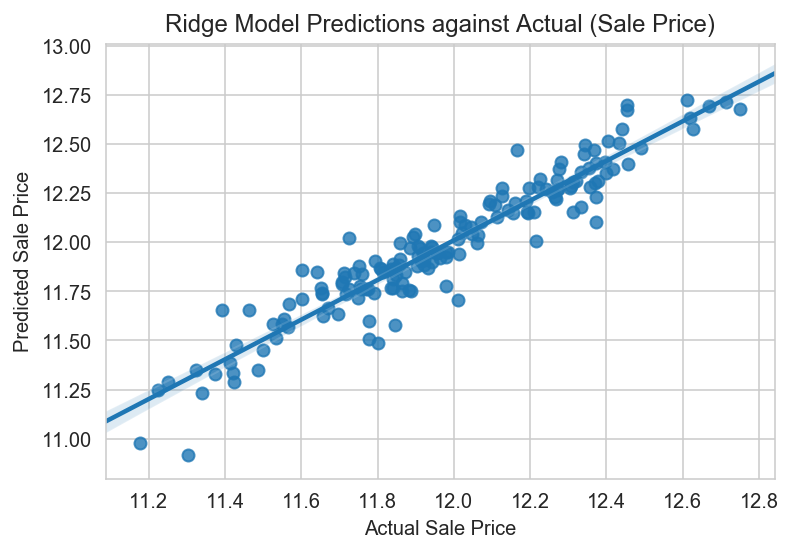

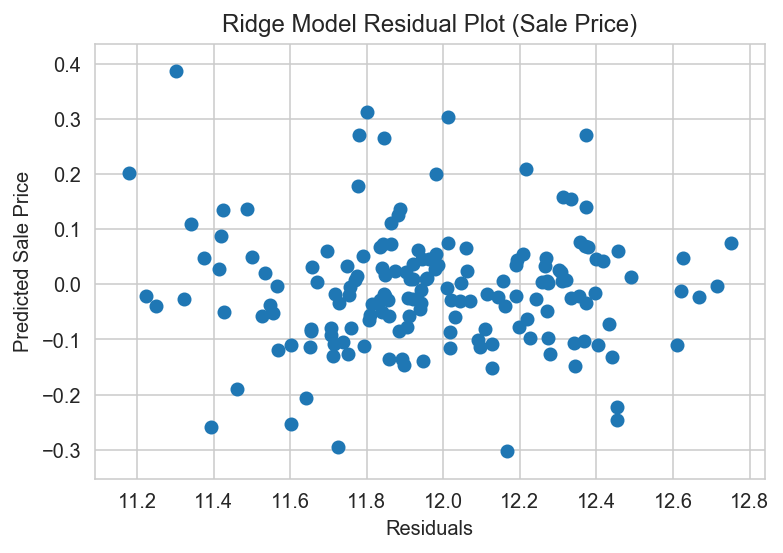

,features,coefficient,abs coefficient
3,OverallQual,0.048805,0.048805
31,TotalSF,0.036888,0.036888
12,GrLivArea,0.034916,0.034916
10,1stFlrSF,0.026095,0.026095
4,YearBuilt,0.024982,0.024982


In [284]:
# Fitting Ridge Regression to the Training set
from sklearn.linear_model import Ridge, RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridgef = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridgef.fit(X_train_std, y_train)

ridgef = Ridge(alpha=optimal_ridgef.alpha_)
ridgef.fit(X_train_std, y_train)

## Calculating cross-validation scores
from sklearn.model_selection import cross_val_score
ridgef_scores = cross_val_score(ridgef, X_train_std, y_train, cv=10)
print('Cross-validation scores:{}'.format(ridgef_scores))
print('Cross-validation scores mean:{}\nCross-validation scores std dev:{}'.format(np.mean(ridgef_scores),np.std(ridgef_scores)))

# Predicting the Test set results
yfsr_pred = ridgef.predict(X_test_std)

## Calculate R^2
from sklearn.metrics import r2_score
print("cross-val R^2:{}".format(r2_score(y_test,yfsr_pred)))

## Plotting predicted values against actual values to find correlation
sns.regplot(yfsr_pred,y_test)
plt.title('Ridge Model Predictions against Actual (Sale Price)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

## Plotting predicted values against actual values to find correlation
plt.scatter(yfsr_pred,(yfsr_pred - y_test))
plt.title('Ridge Model Residual Plot (Sale Price)')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create dataframe of coefficients
results_ridge = pd.DataFrame()
results_ridge['features'] = X_train.columns
results_ridge['coefficient'] = ridgef.coef_
results_ridge['abs coefficient'] = np.abs(ridgef.coef_)
results_ridge.sort_values(by='abs coefficient',ascending=False).head(5)

Cross-validation scores:[0.88695675 0.91898418 0.90832134 0.86594995 0.84948184 0.8561473
 0.87809072 0.8617815  0.89572131 0.88182151]
Cross-validation scores mean:0.8803256392694265
Cross-validation scores std dev:0.021570698075192338
cross-val R^2:0.8937654336792239


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


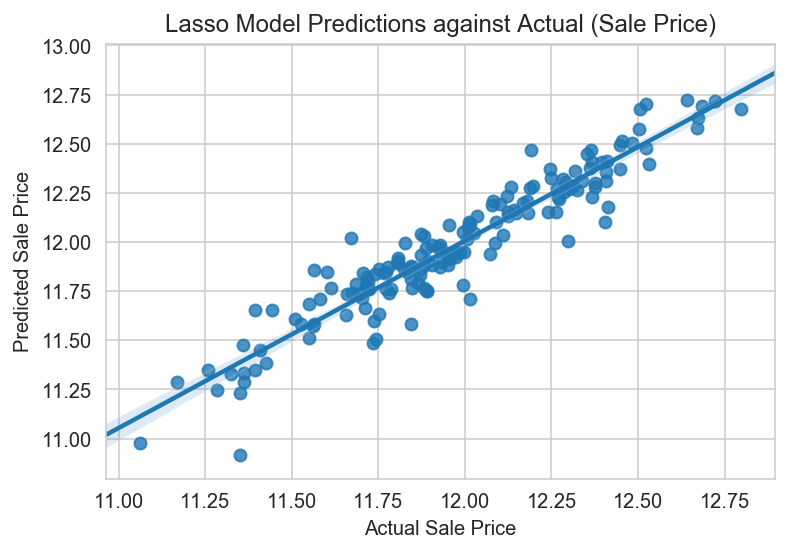

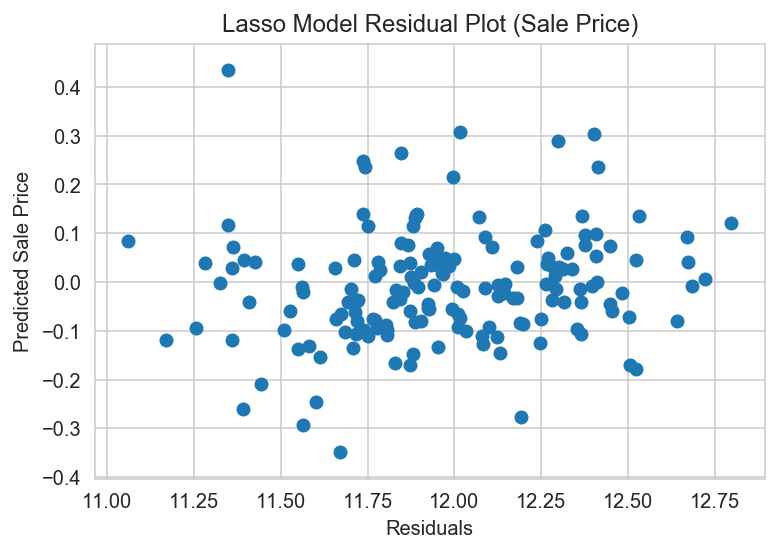

Percent variables zeroed out: 0.00749063670411985


,features,coefficient,abs coefficient
4,YearBuilt,0.072751,0.072751
3,OverallQual,0.060998,0.060998
115,GarageType_Attchd,0.054365,0.054365
121,MiscFeature_None,0.053860,0.053860
31,TotalSF,0.051030,0.051030
119,GarageType_Detchd,0.049742,0.049742
123,MiscFeature_Shed,0.046807,0.046807
11,2ndFlrSF,0.043556,0.043556
12,GrLivArea,0.042263,0.042263
153,OverallCond_3,-0.033506,0.033506


In [285]:
# Fitting Ridge Regression to the Training set
from sklearn.linear_model import Lasso, LassoCV
optimal_lassof = LassoCV(n_alphas=2000, cv=10)
optimal_lassof.fit(X_train_std, y_train)

lassof = Ridge(alpha=optimal_lassof.alpha_)
lassof.fit(X_train_std, y_train)

## Calculating cross-validation scores
from sklearn.model_selection import cross_val_score
lassof_scores = cross_val_score(lassof, X_train_std, y_train, cv=10)
print('Cross-validation scores:{}'.format(lassof_scores))
print('Cross-validation scores mean:{}\nCross-validation scores std dev:{}'.format(np.mean(lassof_scores),np.std(lassof_scores)))

# Predicting the Test set results
yfs_predl = lassof.predict(X_test_std)

## Calculate R^2
from sklearn.metrics import r2_score
print("cross-val R^2:{}".format(r2_score(y_test,yfs_predl)))

## Plotting predicted values against actual values to find correlation
sns.regplot(yfs_predl,y_test)
plt.title('Lasso Model Predictions against Actual (Sale Price)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

## Plotting residual plot
plt.scatter(yfs_predl,(yfs_predl-y_test))
plt.title('Lasso Model Residual Plot (Sale Price)')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Percentage zeroed out
print('Percent variables zeroed out:', np.sum((lassof.coef_ == 0))/float(len(lassof.coef_)))

# Create dataframe of coefficients
results_lasso = pd.DataFrame()
results_lasso['features'] = X_train.columns
results_lasso['coefficient'] = lassof.coef_
results_lasso['abs coefficient'] = np.abs(lassof.coef_)
results_lasso.sort_values(by='abs coefficient',ascending=False).head(20)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [286]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [287]:
# A: